In [1]:
# !pip install shap

In [1]:
import pandas as pd
import numpy as np
import random
import os
import math
from tqdm import tqdm

import matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, accuracy_score

/home/user/anaconda3/envs/bsh/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Utils & preprocess

X = (batch, sequence, dimension)<br>
dimension은 feature 수 , sequence는 timestamp

y = (0,1) <br>
0 = healthy, 1 = failure

In [2]:
def extract_sequences(df, sequence_length, stride = 1 , next_time = True ):
    data_x = []
    assign_nums = df['배정번호'].unique()
    for assign_num in tqdm(assign_nums, total=len(assign_nums), desc='배정번호 별로 추출하는중'):
        sampled_labeled_df = df[df['배정번호']==assign_num]
        sampled_labeled_df = sampled_labeled_df.reset_index(drop=True)
        start_idx = 0
        while start_idx + sequence_length <= len(sampled_labeled_df):
            end_idx = start_idx + sequence_length
            sub_df = sampled_labeled_df.iloc[start_idx:end_idx]
            time_diff = (sub_df['TAG_MIN'].max() - sub_df['TAG_MIN'].min()).seconds
            if time_diff == sequence_length - 1:
                sequence = sub_df.drop(columns=['TAG_MIN', '배정번호','불량여부']).values
                data_x.append(sequence)
                if next_time == True:
                    start_idx = end_idx
                else:
                    start_idx += stride
            else:
                start_idx += stride
    return np.stack(data_x, axis=0)

In [3]:
def make_dataset(data , quality, threshold = 0.1, sequence_length = 60, downsampling = 2000):

    quality['불량률'] = quality['불량수량']/ quality['총수량'] * 100
    quality['불량여부'] = quality['불량률'].apply(lambda x: 1 if x > threshold else 0)
    labeled_df = data.merge(quality[['배정번호','불량여부']], on='배정번호', how='left')
    labeled_df['TAG_MIN'] =pd.to_datetime(labeled_df.TAG_MIN, format='%Y-%m-%d %H:%M:%S')
    labeled_df = labeled_df.dropna() # 지금은 결측치가 있는 행을 제거
    labeled_df_healthy = labeled_df[labeled_df['불량여부']==0]
    labeled_df_failure = labeled_df[labeled_df['불량여부']==1]
    healthy_x = extract_sequences(labeled_df_healthy, sequence_length , stride = 1, next_time = True)
    failure_x = extract_sequences(labeled_df_failure, sequence_length , stride = 1, next_time = True)
    random_indices = np.random.choice(healthy_x.shape[0], downsampling, replace=False)
    healthy_x = healthy_x[random_indices]
    healthy_y = np.zeros(len(healthy_x))
    failure_y = np.ones(len(failure_x))
    x_data = np.concatenate((healthy_x, failure_x), axis=0)
    y_data = np.concatenate((healthy_y, failure_y), axis=0)
    x_data, y_data = shuffle(x_data, y_data, random_state=42)
    return x_data, y_data

In [4]:
def Scaler_split(x_data, y_data,sequence_length = 60):

    number = list(range(1, len(x_data)))
    random.shuffle(number)
    train_ratio = 0.6
    valid_ratio = 0.2

    total_len = len(x_data)
    train_len = int(total_len * train_ratio)
    valid_len = int(total_len * valid_ratio)

    train_num = number[:train_len]
    valid_num = number[train_len:train_len+valid_len]
    test_num = number[train_len+valid_len:]

    X_train = x_data[train_num].reshape((-1,19))
    X_valid = x_data[valid_num].reshape((-1,19))
    X_test = x_data[test_num].reshape((-1,19))

    y_train = y_data[train_num]
    y_valid = y_data[valid_num]
    y_test = y_data[test_num]

    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train = scaler.transform(X_train).reshape((-1,sequence_length,19))
    X_valid = scaler.transform(X_valid).reshape((-1,sequence_length,19))
    X_test = scaler.transform(X_test).reshape((-1,sequence_length,19))

    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [5]:
class MyDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.tensor(x_data, dtype=torch.float32)
        self.y_data = torch.tensor(y_data, dtype=torch.float32)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

In [6]:
def plot_losses(train_losses, valid_losses, epochs):
    plt.figure(figsize=(5, 3))

    # epochs가 int 타입이라면 range로 리스트 생성
    if isinstance(epochs, int):
        epochs = list(range(1, epochs+1))

    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, valid_losses, label='Validation Loss')
    plt.title('Train and Validation Losses over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [7]:
def plot_accuracies(train_accuracies, valid_accuracies, epochs):
    plt.figure(figsize=(5, 3))

    # epochs가 int 타입이라면 range로 리스트 생성
    if isinstance(epochs, int):
        epochs = list(range(1, epochs+1))

    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, valid_accuracies, label='Validation Accuracy')
    plt.title('Train and Validation Accuracies over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [8]:
def test(model, test_loader):
    model.eval()

    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(device)
            y_data_batch = y_data_batch.to(device)

            probabilities = model(x_data_batch)[:, 1]
            all_probabilities.extend(probabilities.cpu().numpy())
            all_labels.extend(y_data_batch.cpu().numpy())

    all_predictions = [1 if prob > 0.5 else 0 for prob in all_probabilities]

    f1 = f1_score(all_labels, all_predictions, average='macro')
    auroc = roc_auc_score(all_labels, all_probabilities)
    accuracy = accuracy_score(all_labels, all_predictions)

    return f1, auroc, accuracy, all_labels, all_probabilities

In [9]:
def plot_roc_curve(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.plot(fpr, tpr, linestyle='-', label='Model')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# Model

In [10]:
class Embedding(nn.Module):
  def __init__(self,config):
    super().__init__()
    self.position_embeddings = nn.Embedding(config.sequence_length, config.input_feature)
    self.norm_layer = nn.LayerNorm(config.input_feature , eps=1e-12)
    self.dropout = nn.Dropout()

  def forward(self, input_tensor):
      device = input_tensor.device  # input_tensor의 디바이스를 가져옵니다.
      input_pos = torch.arange(input_tensor.size(1), dtype=torch.long, device=device)  # 디바이스를 지정하여 input_pos를 생성합니다.
      pos_emb = self.position_embeddings(input_pos).unsqueeze(0)
      final_emb = input_tensor + pos_emb
      final_emb = self.norm_layer(final_emb)
      final_emb = self.dropout(final_emb)
      return final_emb

In [11]:
from math import sqrt
def scaled_dot_product(query,key,value):
  dim_k = query.size(-1)
  similiarity = torch.bmm(query, key.transpose(1,2)) / sqrt(dim_k)
  similiarity = F.softmax(similiarity, dim = -1) #여기 조심하자
  return torch.bmm(similiarity,value)

In [12]:
class Attention_head(nn.Module):
  def __init__(self, emb_dim, head_dim):
    super().__init__()
    self.query = nn.Linear(emb_dim, head_dim)
    self.key = nn.Linear(emb_dim, head_dim)
    self.value = nn.Linear(emb_dim, head_dim)

  def forward(self, final_emb):
    q = self.query(final_emb)
    k = self.key(final_emb)
    v = self.value(final_emb)
    return scaled_dot_product(q, k, v)

In [13]:
class Multihead_attention(nn.Module):
  def __init__(self,config):
    super().__init__()
    input_feature = config.input_feature
    self.attention_heads = nn.ModuleList([Attention_head(input_feature,4),
                                          Attention_head(input_feature,4),
                                          Attention_head(input_feature,4),
                                          Attention_head(input_feature,4),
                                          Attention_head(input_feature,3)])
    self.dense_layer = nn.Linear(input_feature, input_feature)

  def forward(self, final_emb):
    x = torch.cat([h(final_emb) for h in self.attention_heads],dim = -1)
    x = self.dense_layer(x)
    return x

In [14]:
class Feedforward(nn.Module):
  def __init__(self,config):
    super().__init__()
    self.layer1 = nn.Linear(config.input_feature, config.feed_foward_dim)
    self.layer2 = nn.Linear(config.feed_foward_dim, config.input_feature)
    self.gelu = nn.GELU()
    self.dropout = nn.Dropout()

  def forward(self, x):
    x = self.layer1(x)
    x = self.gelu(x)
    x = self.layer2(x)
    x = self.dropout(x)
    return x

In [15]:
class TransformerEncoderLayer(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.Norm1 = nn.LayerNorm(config.input_feature)
    self.Norm2 = nn.LayerNorm(config.input_feature)
    self.attention = Multihead_attention(config)
    self.feedforward = Feedforward(config)

  def forward(self,x):
    norm = self.Norm1(x)
    x = x + self.attention(norm)
    x = x + self.feedforward(self.Norm2(x))
    return x

In [16]:
class AttentionMechanism(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.query = nn.Linear(hidden_size, hidden_size)
        self.key = nn.Linear(hidden_size, hidden_size)

    def forward(self, x):
        q = self.query(x)
        k = self.key(x)
        dim_k = q.size(-1)

        attention_scores = torch.matmul(q, k.transpose(-2, -1)) / (dim_k ** 0.5)
        attention_weights = F.softmax(attention_scores, dim=-1)

        weighted_average = torch.matmul(attention_weights, x)

        return weighted_average.mean(dim=1)

In [17]:
class TransformerEncoder(nn.Module):
  def __init__(self,config):
    super().__init__()
    self.embedding = Embedding(config)
    self.layers = nn.ModuleList([TransformerEncoderLayer(config) for i in range(config.num_layers)])
    self.attention = AttentionMechanism(config.input_feature)
    self.classifier = nn.Linear(config.input_feature, 2)

  def forward(self,x):
    x = self.embedding(x)
    for layer in self.layers:
      x = layer(x)
    x = self.attention(x)
    x = self.classifier(x)
    return x

# trainer 구현

In [18]:
class Trainer():
  def __init__(self, model, optimizer, loss_function, device):
    super().__init__()
    self.model = model
    self.optimizer = optimizer
    self.loss_function = loss_function
    self.device = device

  def train(self, train_loader, config):
    self.model.train()

    total_loss = 0
    total_correct = 0

    batch_size = train_loader.batch_size
    total_dataset_size = len(train_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    for batch in tqdm( train_loader, total = num_batches ):
      self.optimizer.zero_grad()

      x_data_batch, y_data_batch = batch

      x_data_batch = x_data_batch.to(self.device)
      y_data_batch = y_data_batch.to(self.device)

      outputs = self.model(x_data_batch)
      loss = self.loss_function(outputs, y_data_batch.long())
      total_loss += loss.item()

      #역전파
      loss.backward()
      self.optimizer.step()

      _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
      correct = (predicted == y_data_batch).sum().item()
      total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def valid(self, valid_loader, config):
    self.model.eval()  # 모델을 평가 모드로 전환

    total_loss = 0
    total_correct = 0

    batch_size = valid_loader.batch_size
    total_dataset_size = len(valid_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    with torch.no_grad():  # 그래디언트 계산을 비활성화
        for batch in tqdm(valid_loader, total=num_batches):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(self.device)
            y_data_batch = y_data_batch.to(self.device)

            outputs = self.model(x_data_batch)
            loss = self.loss_function(outputs, y_data_batch.long())
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
            correct = (predicted == y_data_batch).sum().item()
            total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def test(self, test_loader, config):
    self.model.eval()  # 모델을 평가 모드로 전환

    total_loss = 0
    total_correct = 0

    batch_size = test_loader.batch_size
    total_dataset_size = len(test_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    with torch.no_grad():  # 그래디언트 계산을 비활성화
        for batch in tqdm(test_loader, total=num_batches):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(self.device)
            y_data_batch = y_data_batch.to(self.device)

            outputs = self.model(x_data_batch)
            loss = self.loss_function(outputs, y_data_batch.long())
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
            correct = (predicted == y_data_batch).sum().item()
            total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def save_model(self, epoch, path="model_checkpoint"):
    model_path = f"{path}_epoch_{epoch}.pth"
    torch.save(self.model.state_dict(), model_path)
    print(f"Model saved")

  def save_best_model(self, path="model_checkpoint"):
    model_path = f"{path}_best_model.pth"
    torch.save(self.model.state_dict(), model_path)
    print(f"Model saved")

# Main

In [19]:
class Config():
  threshold = 0.1        # 불량률을 몇 퍼센트까지 0.1로 정의할 것인지
  sequence_length = 60   # 몇초를 하나의 instance로 볼 것인지
  downsampling = 2000    # healthy data를 몇개를 쓸지
  EPOCH = 200
  LEARNING_RATE = 0.001
  BATCH_SIZE = 256
  SEED = 42
  input_feature = 19     # input feature 이거 바꾸면 모델 안 돌아감
  feed_foward_dim = 100  # feed forward dimension
  num_layers = 12        # encoder block 개수

config = Config()

In [20]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(config.SEED) # Seed 고정

In [21]:
df = pd.read_csv('/home/user/Desktop/bsh/absoluteA/data/data.csv',encoding = 'cp949')
quality = pd.read_excel('/home/user/Desktop/bsh/absoluteA/data/quality.xlsx')

In [22]:
# 정의한 기준에 맞게 label하고 정해준 시간만큼 split하고 dataset만들기
x_data, y_data = make_dataset(df,quality , threshold = config.threshold, sequence_length = config.sequence_length, downsampling = config.downsampling )

배정번호 별로 추출하는중: 100%|██████████| 7/7 [00:03<00:00,  1.89it/s]


In [23]:
print('healthy(0)의 개수 :',int(len(y_data)-y_data.sum()))
print('failure(1)의 개수 :',int(y_data.sum()))

healthy(0)의 개수 : 2000
failure(1)의 개수 : 1569


In [24]:
X_train, X_valid, X_test, y_train, y_valid, y_test = Scaler_split(x_data, y_data, sequence_length = config.sequence_length)

In [25]:
# 인스턴스 생성
train_dataset = MyDataset(X_train, y_train)
valid_dataset = MyDataset(X_valid, y_valid)
test_dataset = MyDataset(X_test, y_test)

del X_train, X_valid, X_test, y_train, y_valid, y_test

In [26]:
# batch로 분할
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=True)

In [27]:
#데이터 수 확인
total_train_data = len(train_loader.dataset)
print(f"Total number of data samples in train_loader: {total_train_data}")
total_valid_data = len(valid_loader.dataset)
print(f"Total number of data samples in valid_loader: {total_valid_data}")
total_test_data = len(test_loader.dataset)
print(f"Total number of data samples in test_loader: {total_test_data}")

Total number of data samples in train_loader: 2141
Total number of data samples in valid_loader: 713
Total number of data samples in test_loader: 714


In [28]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [29]:
# model, optimizer, loss_function 구현하고 결합시키기
model = TransformerEncoder(config)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=config.LEARNING_RATE)
loss_function = nn.CrossEntropyLoss()
trainer = Trainer(model, optimizer, loss_function, device)

In [31]:
# save path 지정 잘해줄 것!!!!!!!!(일단 지금은 저장하지 말자)
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
valid_accuracy_save = 0
best_epoch_save = 0 

for epoch in range(config.EPOCH):
    print('=====================================================================================')
    print("epoch {}".format(epoch+1))

    train_loss, train_accuracy = trainer.train(train_loader, config)
    valid_loss, valid_accuracy = trainer.valid(valid_loader, config)
    if valid_accuracy_save < valid_accuracy :
      trainer.save_best_model(path = '/home/user/Desktop/bsh/absoluteA/model/2000_Transformer') # 이 부분!!!!
      valid_accuracy_save = valid_accuracy
      best_epoch_save = epoch + 1

    # 결과값을 리스트에 추가
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

    print("TRAIN LOSS = {}, TRAIN ACC = {}, ".format(train_loss, train_accuracy))
    print("VALID LOSS = {}, VALID ACC = {}, ".format(valid_loss, valid_accuracy))

epoch 1


100%|██████████| 3/3 [00:00<00:00, 66.24it/s]


Model saved
TRAIN LOSS = 0.003153348097117467, TRAIN ACC = 0.4936945352638954, 
VALID LOSS = 0.002642152018500244, VALID ACC = 0.6465638148667602, 
epoch 2


100%|██████████| 3/3 [00:00<00:00, 90.50it/s]


TRAIN LOSS = 0.0027037434408676954, TRAIN ACC = 0.6324147594581971, 
VALID LOSS = 0.0025913844101893785, VALID ACC = 0.6339410939691444, 
epoch 3


100%|██████████| 3/3 [00:00<00:00, 96.03it/s]


TRAIN LOSS = 0.002578395986490192, TRAIN ACC = 0.6539000467071462, 
VALID LOSS = 0.0026554693513632156, VALID ACC = 0.6437587657784011, 
epoch 4


100%|██████████| 3/3 [00:00<00:00, 91.25it/s]


Model saved
TRAIN LOSS = 0.0025314914183547596, TRAIN ACC = 0.6473610462400747, 
VALID LOSS = 0.002560907710986251, VALID ACC = 0.6633941093969145, 
epoch 5


100%|██████████| 3/3 [00:00<00:00, 97.50it/s]


Model saved
TRAIN LOSS = 0.002461535526402138, TRAIN ACC = 0.6674451191032228, 
VALID LOSS = 0.0025385669203994987, VALID ACC = 0.6746143057503506, 
epoch 6


100%|██████████| 3/3 [00:00<00:00, 100.38it/s]


Model saved
TRAIN LOSS = 0.0024098792347825616, TRAIN ACC = 0.6856609061186362, 
VALID LOSS = 0.002458618700420706, VALID ACC = 0.6830294530154277, 
epoch 7


100%|██████████| 3/3 [00:00<00:00, 88.47it/s]


TRAIN LOSS = 0.0024095983050906283, TRAIN ACC = 0.6926669780476413, 
VALID LOSS = 0.00250313860504022, VALID ACC = 0.6661991584852734, 
epoch 8


100%|██████████| 3/3 [00:00<00:00, 86.15it/s]


Model saved
TRAIN LOSS = 0.002355118184265607, TRAIN ACC = 0.6898645492760392, 
VALID LOSS = 0.0024244451756898684, VALID ACC = 0.6914446002805049, 
epoch 9


100%|██████████| 3/3 [00:00<00:00, 98.23it/s]


Model saved
TRAIN LOSS = 0.00230311222691115, TRAIN ACC = 0.7057449789817842, 
VALID LOSS = 0.002576356850365937, VALID ACC = 0.6956521739130435, 
epoch 10


100%|██████████| 3/3 [00:00<00:00, 95.62it/s]


Model saved
TRAIN LOSS = 0.0023177672161893387, TRAIN ACC = 0.6996730499766465, 
VALID LOSS = 0.0023733349869662548, VALID ACC = 0.7124824684431977, 
epoch 11


100%|██████████| 3/3 [00:00<00:00, 99.66it/s]


Model saved
TRAIN LOSS = 0.002281930946624485, TRAIN ACC = 0.7085474077533863, 
VALID LOSS = 0.0023304199771158824, VALID ACC = 0.729312762973352, 
epoch 12


100%|██████████| 3/3 [00:00<00:00, 99.03it/s]


Model saved
TRAIN LOSS = 0.002236707933814322, TRAIN ACC = 0.7099486221391873, 
VALID LOSS = 0.002363651447510151, VALID ACC = 0.7307152875175316, 
epoch 13


100%|██████████| 3/3 [00:00<00:00, 86.95it/s]


Model saved
TRAIN LOSS = 0.002194116030380805, TRAIN ACC = 0.726296123306866, 
VALID LOSS = 0.0023295114033687, VALID ACC = 0.7363253856942497, 
epoch 14


100%|██████████| 3/3 [00:00<00:00, 98.73it/s]


TRAIN LOSS = 0.0022267830783883192, TRAIN ACC = 0.7202241943017281, 
VALID LOSS = 0.002352847457768038, VALID ACC = 0.7307152875175316, 
epoch 15


100%|██████████| 3/3 [00:00<00:00, 97.43it/s]


TRAIN LOSS = 0.0022004646071202842, TRAIN ACC = 0.7253619803829986, 
VALID LOSS = 0.0024702321596934786, VALID ACC = 0.7124824684431977, 
epoch 16


100%|██████████| 3/3 [00:00<00:00, 98.48it/s]


Model saved
TRAIN LOSS = 0.0022185396251696286, TRAIN ACC = 0.7234936945352639, 
VALID LOSS = 0.0022592282897125286, VALID ACC = 0.7447405329593267, 
epoch 17


100%|██████████| 3/3 [00:00<00:00, 99.76it/s]


TRAIN LOSS = 0.0021751088580479415, TRAIN ACC = 0.7370387669313405, 
VALID LOSS = 0.0023101488804917517, VALID ACC = 0.7377279102384292, 
epoch 18


100%|██████████| 3/3 [00:00<00:00, 94.29it/s]


TRAIN LOSS = 0.0021503944783386702, TRAIN ACC = 0.7356375525455394, 
VALID LOSS = 0.002252062315024634, VALID ACC = 0.7391304347826086, 
epoch 19


100%|██████████| 3/3 [00:00<00:00, 98.56it/s]


Model saved
TRAIN LOSS = 0.0021439438415208414, TRAIN ACC = 0.7389070527790752, 
VALID LOSS = 0.0023090810963014067, VALID ACC = 0.7559607293127629, 
epoch 20


100%|██████████| 3/3 [00:00<00:00, 98.26it/s]


TRAIN LOSS = 0.0021285463693486036, TRAIN ACC = 0.7309668379262028, 
VALID LOSS = 0.002156344068669002, VALID ACC = 0.7419354838709677, 
epoch 21


100%|██████████| 3/3 [00:00<00:00, 98.98it/s]


TRAIN LOSS = 0.0021016047915138414, TRAIN ACC = 0.7431106959364783, 
VALID LOSS = 0.002436677252594251, VALID ACC = 0.726507713884993, 
epoch 22


100%|██████████| 3/3 [00:00<00:00, 93.08it/s]


TRAIN LOSS = 0.002125124517081776, TRAIN ACC = 0.7216254086875292, 
VALID LOSS = 0.002405776633119516, VALID ACC = 0.7138849929873773, 
epoch 23


100%|██████████| 3/3 [00:00<00:00, 96.58it/s]


TRAIN LOSS = 0.0021877416463056383, TRAIN ACC = 0.7225595516113965, 
VALID LOSS = 0.002216986862506305, VALID ACC = 0.7391304347826086, 
epoch 24


100%|██████████| 3/3 [00:00<00:00, 91.99it/s]


Model saved
TRAIN LOSS = 0.0021207177683550973, TRAIN ACC = 0.7482484820177487, 
VALID LOSS = 0.0021439617261980225, VALID ACC = 0.7657784011220197, 
epoch 25


100%|██████████| 3/3 [00:00<00:00, 92.93it/s]


TRAIN LOSS = 0.0021027113471505576, TRAIN ACC = 0.7379729098552078, 
VALID LOSS = 0.002472887617675653, VALID ACC = 0.6942496493688639, 
epoch 26


100%|██████████| 3/3 [00:00<00:00, 96.33it/s]


Model saved
TRAIN LOSS = 0.002075944295947321, TRAIN ACC = 0.7393741242410089, 
VALID LOSS = 0.0021201707370485197, VALID ACC = 0.7812061711079944, 
epoch 27


100%|██████████| 3/3 [00:00<00:00, 99.49it/s]


TRAIN LOSS = 0.002068026677741452, TRAIN ACC = 0.7519850537132181, 
VALID LOSS = 0.0022399634081050022, VALID ACC = 0.7237026647966339, 
epoch 28


100%|██████████| 3/3 [00:00<00:00, 98.75it/s]


TRAIN LOSS = 0.0020729354445703785, TRAIN ACC = 0.7468472676319476, 
VALID LOSS = 0.0023706598000974508, VALID ACC = 0.7377279102384292, 
epoch 29


100%|██████████| 3/3 [00:00<00:00, 98.04it/s]


TRAIN LOSS = 0.002018812060745895, TRAIN ACC = 0.7529191966370855, 
VALID LOSS = 0.002223331998474635, VALID ACC = 0.7419354838709677, 
epoch 30


100%|██████████| 3/3 [00:00<00:00, 98.52it/s]


TRAIN LOSS = 0.0020375062460545232, TRAIN ACC = 0.762260625875759, 
VALID LOSS = 0.0022003731336366246, VALID ACC = 0.7517531556802244, 
epoch 31


100%|██████████| 3/3 [00:00<00:00, 97.23it/s]


TRAIN LOSS = 0.0020277094390001435, TRAIN ACC = 0.7533862680990191, 
VALID LOSS = 0.0020186932441395764, VALID ACC = 0.7699859747545582, 
epoch 32


100%|██████████| 3/3 [00:00<00:00, 97.74it/s]


TRAIN LOSS = 0.0019940563391881924, TRAIN ACC = 0.7566557683325549, 
VALID LOSS = 0.0021846213314008246, VALID ACC = 0.7447405329593267, 
epoch 33


100%|██████████| 3/3 [00:00<00:00, 98.31it/s]


TRAIN LOSS = 0.0019956903583476723, TRAIN ACC = 0.7687996263428305, 
VALID LOSS = 0.001979334073514791, VALID ACC = 0.7699859747545582, 
epoch 34


100%|██████████| 3/3 [00:00<00:00, 100.07it/s]


TRAIN LOSS = 0.001985450594963063, TRAIN ACC = 0.7631947687996263, 
VALID LOSS = 0.001944736879303278, VALID ACC = 0.7755960729312763, 
epoch 35


100%|██████████| 3/3 [00:00<00:00, 98.98it/s]


TRAIN LOSS = 0.001892049490208383, TRAIN ACC = 0.7758056982718355, 
VALID LOSS = 0.0019714805972860373, VALID ACC = 0.7812061711079944, 
epoch 36


100%|██████████| 3/3 [00:00<00:00, 99.44it/s]


Model saved
TRAIN LOSS = 0.00189604318236592, TRAIN ACC = 0.7748715553479683, 
VALID LOSS = 0.001871444483458745, VALID ACC = 0.7980364656381487, 
epoch 37


100%|██████████| 3/3 [00:00<00:00, 99.26it/s]


TRAIN LOSS = 0.0019009865399333486, TRAIN ACC = 0.7786081270434376, 
VALID LOSS = 0.0018065053483714228, VALID ACC = 0.7980364656381487, 
epoch 38


100%|██████████| 3/3 [00:00<00:00, 89.63it/s]


TRAIN LOSS = 0.00192297514160901, TRAIN ACC = 0.7832788416627744, 
VALID LOSS = 0.0021710916622156517, VALID ACC = 0.7699859747545582, 
epoch 39


100%|██████████| 3/3 [00:00<00:00, 98.69it/s]


TRAIN LOSS = 0.0018523292444621998, TRAIN ACC = 0.7846800560485754, 
VALID LOSS = 0.002228192326731635, VALID ACC = 0.7461430575035063, 
epoch 40


100%|██████████| 3/3 [00:00<00:00, 98.75it/s]


TRAIN LOSS = 0.0017695967725703005, TRAIN ACC = 0.7972909855207847, 
VALID LOSS = 0.0020359707748070673, VALID ACC = 0.7798036465638148, 
epoch 41


100%|██████████| 3/3 [00:00<00:00, 98.05it/s]


TRAIN LOSS = 0.001785397877597408, TRAIN ACC = 0.8010275572162541, 
VALID LOSS = 0.0017975597612319453, VALID ACC = 0.7938288920056101, 
epoch 42


100%|██████████| 3/3 [00:00<00:00, 98.23it/s]


TRAIN LOSS = 0.0017099766072019803, TRAIN ACC = 0.8047641289117234, 
VALID LOSS = 0.001987328243456248, VALID ACC = 0.7741935483870968, 
epoch 43


100%|██████████| 3/3 [00:00<00:00, 95.60it/s]


TRAIN LOSS = 0.0017757221172480648, TRAIN ACC = 0.7991592713685194, 
VALID LOSS = 0.002214160783093574, VALID ACC = 0.7503506311360448, 
epoch 44


100%|██████████| 3/3 [00:00<00:00, 94.81it/s]


TRAIN LOSS = 0.0018325445113032848, TRAIN ACC = 0.7758056982718355, 
VALID LOSS = 0.002188702661225371, VALID ACC = 0.7489481065918654, 
epoch 45


100%|██████████| 3/3 [00:00<00:00, 96.38it/s]


TRAIN LOSS = 0.0017218957961802725, TRAIN ACC = 0.8033629145259225, 
VALID LOSS = 0.002455417855758988, VALID ACC = 0.7012622720897616, 
epoch 46


100%|██████████| 3/3 [00:00<00:00, 92.55it/s]


TRAIN LOSS = 0.0017323311747150518, TRAIN ACC = 0.8085007006071929, 
VALID LOSS = 0.0021723429835695373, VALID ACC = 0.7461430575035063, 
epoch 47


100%|██████████| 3/3 [00:00<00:00, 89.86it/s]


Model saved
TRAIN LOSS = 0.0017446894781548306, TRAIN ACC = 0.8070994862213918, 
VALID LOSS = 0.0018034914683493124, VALID ACC = 0.8120617110799438, 
epoch 48


100%|██████████| 3/3 [00:00<00:00, 97.26it/s]


TRAIN LOSS = 0.0016828597789053492, TRAIN ACC = 0.8066324147594582, 
VALID LOSS = 0.001991447693502418, VALID ACC = 0.7840112201963534, 
epoch 49


100%|██████████| 3/3 [00:00<00:00, 94.83it/s]


TRAIN LOSS = 0.0016885913459567588, TRAIN ACC = 0.8085007006071929, 
VALID LOSS = 0.0021788444040868257, VALID ACC = 0.7573632538569425, 
epoch 50


100%|██████████| 3/3 [00:00<00:00, 94.00it/s]


TRAIN LOSS = 0.0016462893087359467, TRAIN ACC = 0.8131714152265297, 
VALID LOSS = 0.0019756340713019457, VALID ACC = 0.7643758765778401, 
epoch 51


100%|██████████| 3/3 [00:00<00:00, 91.02it/s]


TRAIN LOSS = 0.001713748654156631, TRAIN ACC = 0.8122372723026623, 
VALID LOSS = 0.0020605800529683287, VALID ACC = 0.7727910238429172, 
epoch 52


100%|██████████| 3/3 [00:00<00:00, 97.08it/s]


TRAIN LOSS = 0.0016731335035499598, TRAIN ACC = 0.8136384866884633, 
VALID LOSS = 0.0019323270752252737, VALID ACC = 0.7713884992987378, 
epoch 53


100%|██████████| 3/3 [00:00<00:00, 98.76it/s]


TRAIN LOSS = 0.0016531319971231587, TRAIN ACC = 0.8122372723026623, 
VALID LOSS = 0.0018849482375809723, VALID ACC = 0.8022440392706872, 
epoch 54


100%|██████████| 3/3 [00:00<00:00, 101.17it/s]


TRAIN LOSS = 0.001619841731190403, TRAIN ACC = 0.8201774871555348, 
VALID LOSS = 0.001726224287027731, VALID ACC = 0.8008415147265077, 
epoch 55


100%|██████████| 3/3 [00:00<00:00, 95.25it/s]


TRAIN LOSS = 0.0015758086815441618, TRAIN ACC = 0.8225128444652032, 
VALID LOSS = 0.0021320753645930352, VALID ACC = 0.7559607293127629, 
epoch 56


100%|██████████| 3/3 [00:00<00:00, 94.85it/s]


TRAIN LOSS = 0.0015342907613819306, TRAIN ACC = 0.8267164876226063, 
VALID LOSS = 0.0017815486411727327, VALID ACC = 0.7966339410939691, 
epoch 57


100%|██████████| 3/3 [00:00<00:00, 88.88it/s]


TRAIN LOSS = 0.0016062935898650311, TRAIN ACC = 0.8225128444652032, 
VALID LOSS = 0.0019579885049421358, VALID ACC = 0.7699859747545582, 
epoch 58


100%|██████████| 3/3 [00:00<00:00, 96.38it/s]


TRAIN LOSS = 0.001513686568755961, TRAIN ACC = 0.8337225595516113, 
VALID LOSS = 0.0019182228440154986, VALID ACC = 0.7868162692847125, 
epoch 59


100%|██████████| 3/3 [00:00<00:00, 99.16it/s]


TRAIN LOSS = 0.0015563482800581253, TRAIN ACC = 0.8304530593180757, 
VALID LOSS = 0.001918974757027325, VALID ACC = 0.7741935483870968, 
epoch 60


100%|██████████| 3/3 [00:00<00:00, 97.31it/s]


TRAIN LOSS = 0.0015372439335017269, TRAIN ACC = 0.8234469873890705, 
VALID LOSS = 0.0020087192887845245, VALID ACC = 0.761570827489481, 
epoch 61


100%|██████████| 3/3 [00:00<00:00, 99.57it/s]


TRAIN LOSS = 0.0015341967887156816, TRAIN ACC = 0.8295189163942083, 
VALID LOSS = 0.001959077021182837, VALID ACC = 0.7727910238429172, 
epoch 62


100%|██████████| 3/3 [00:00<00:00, 97.88it/s]


TRAIN LOSS = 0.0015722999000371144, TRAIN ACC = 0.8262494161606726, 
VALID LOSS = 0.002175294500246623, VALID ACC = 0.7489481065918654, 
epoch 63


100%|██████████| 3/3 [00:00<00:00, 100.25it/s]


TRAIN LOSS = 0.0014603870708994751, TRAIN ACC = 0.8383932741709481, 
VALID LOSS = 0.0026595748825126745, VALID ACC = 0.7251051893408135, 
epoch 64


100%|██████████| 3/3 [00:00<00:00, 98.49it/s]


TRAIN LOSS = 0.0015624415117243304, TRAIN ACC = 0.8323213451658104, 
VALID LOSS = 0.0019404802466174496, VALID ACC = 0.7657784011220197, 
epoch 65


100%|██████████| 3/3 [00:00<00:00, 99.81it/s]


TRAIN LOSS = 0.0015950015859590519, TRAIN ACC = 0.8108360579168613, 
VALID LOSS = 0.001982188366907342, VALID ACC = 0.7938288920056101, 
epoch 66


100%|██████████| 3/3 [00:00<00:00, 99.72it/s]


TRAIN LOSS = 0.0016371918331513277, TRAIN ACC = 0.8215787015413358, 
VALID LOSS = 0.0022690064609468736, VALID ACC = 0.7110799438990182, 
epoch 67


100%|██████████| 3/3 [00:00<00:00, 97.95it/s]


TRAIN LOSS = 0.0016074151510615485, TRAIN ACC = 0.8267164876226063, 
VALID LOSS = 0.001872487063160451, VALID ACC = 0.7868162692847125, 
epoch 68


100%|██████████| 3/3 [00:00<00:00, 96.66it/s]


TRAIN LOSS = 0.0015590434901795616, TRAIN ACC = 0.8318542737038767, 
VALID LOSS = 0.0019169148857095298, VALID ACC = 0.782608695652174, 
epoch 69


100%|██████████| 3/3 [00:00<00:00, 98.61it/s]


TRAIN LOSS = 0.0015275332900977815, TRAIN ACC = 0.8323213451658104, 
VALID LOSS = 0.0018246111996879418, VALID ACC = 0.7966339410939691, 
epoch 70


100%|██████████| 3/3 [00:00<00:00, 98.70it/s]


TRAIN LOSS = 0.0014121613453504695, TRAIN ACC = 0.8514712751050911, 
VALID LOSS = 0.002165929130885912, VALID ACC = 0.7531556802244039, 
epoch 71


100%|██████████| 3/3 [00:00<00:00, 98.54it/s]


TRAIN LOSS = 0.0014669871090840425, TRAIN ACC = 0.8374591312470808, 
VALID LOSS = 0.0022078526805861635, VALID ACC = 0.7559607293127629, 
epoch 72


100%|██████████| 3/3 [00:00<00:00, 92.65it/s]


TRAIN LOSS = 0.0014933839210668827, TRAIN ACC = 0.8243811303129379, 
VALID LOSS = 0.0020272445879343684, VALID ACC = 0.7713884992987378, 
epoch 73


100%|██████████| 3/3 [00:00<00:00, 99.29it/s]


TRAIN LOSS = 0.0014292018288822165, TRAIN ACC = 0.8453993460999533, 
VALID LOSS = 0.0024195825903144826, VALID ACC = 0.7419354838709677, 
epoch 74


100%|██████████| 3/3 [00:00<00:00, 98.73it/s]


TRAIN LOSS = 0.0015512695244571306, TRAIN ACC = 0.8365249883232134, 
VALID LOSS = 0.0017730222510756483, VALID ACC = 0.7994389901823282, 
epoch 75


100%|██████████| 3/3 [00:00<00:00, 98.39it/s]


TRAIN LOSS = 0.0013700008587211384, TRAIN ACC = 0.8580102755721626, 
VALID LOSS = 0.002037620811943921, VALID ACC = 0.7713884992987378, 
epoch 76


100%|██████████| 3/3 [00:00<00:00, 87.07it/s]


TRAIN LOSS = 0.0014627128769893727, TRAIN ACC = 0.8318542737038767, 
VALID LOSS = 0.0021650761491285968, VALID ACC = 0.7545582047685835, 
epoch 77


100%|██████████| 3/3 [00:00<00:00, 99.63it/s]


TRAIN LOSS = 0.0013749120058383078, TRAIN ACC = 0.8468005604857544, 
VALID LOSS = 0.0017457020901362993, VALID ACC = 0.8092566619915849, 
epoch 78


100%|██████████| 3/3 [00:00<00:00, 99.51it/s]


TRAIN LOSS = 0.001421893216471202, TRAIN ACC = 0.8397944885567492, 
VALID LOSS = 0.001908139418418745, VALID ACC = 0.8064516129032258, 
epoch 79


100%|██████████| 3/3 [00:00<00:00, 79.81it/s]


TRAIN LOSS = 0.0013997938548332618, TRAIN ACC = 0.8505371321812237, 
VALID LOSS = 0.0018367114441592094, VALID ACC = 0.7952314165497896, 
epoch 80


100%|██████████| 3/3 [00:00<00:00, 100.36it/s]


TRAIN LOSS = 0.0013931809408204792, TRAIN ACC = 0.85007006071929, 
VALID LOSS = 0.0021563105044826386, VALID ACC = 0.7657784011220197, 
epoch 81


100%|██████████| 3/3 [00:00<00:00, 97.80it/s]


TRAIN LOSS = 0.0013888283680110042, TRAIN ACC = 0.8528724894908921, 
VALID LOSS = 0.0019299118331572117, VALID ACC = 0.7812061711079944, 
epoch 82


100%|██████████| 3/3 [00:00<00:00, 74.35it/s]


TRAIN LOSS = 0.0013713556324862141, TRAIN ACC = 0.8510042036431574, 
VALID LOSS = 0.001888807868221866, VALID ACC = 0.7868162692847125, 
epoch 83


100%|██████████| 3/3 [00:00<00:00, 92.60it/s]


TRAIN LOSS = 0.0013114918146886207, TRAIN ACC = 0.8514712751050911, 
VALID LOSS = 0.0018312270226685898, VALID ACC = 0.8064516129032258, 
epoch 84


100%|██████████| 3/3 [00:00<00:00, 94.95it/s]


TRAIN LOSS = 0.0013577252946574796, TRAIN ACC = 0.8463334890238207, 
VALID LOSS = 0.0019206911283656224, VALID ACC = 0.7840112201963534, 
epoch 85


100%|██████████| 3/3 [00:00<00:00, 97.97it/s]


TRAIN LOSS = 0.0013783571737940653, TRAIN ACC = 0.8542737038766931, 
VALID LOSS = 0.001997194275113677, VALID ACC = 0.7671809256661991, 
epoch 86


100%|██████████| 3/3 [00:00<00:00, 86.76it/s]


TRAIN LOSS = 0.0013766344436581365, TRAIN ACC = 0.8519383465670247, 
VALID LOSS = 0.0020543158388739717, VALID ACC = 0.788218793828892, 
epoch 87


100%|██████████| 3/3 [00:00<00:00, 100.65it/s]


TRAIN LOSS = 0.0013503051845340293, TRAIN ACC = 0.8533395609528258, 
VALID LOSS = 0.001992333570670279, VALID ACC = 0.7769985974754559, 
epoch 88


100%|██████████| 3/3 [00:00<00:00, 99.52it/s]


TRAIN LOSS = 0.0013704375650547532, TRAIN ACC = 0.845866417561887, 
VALID LOSS = 0.0022044875260656713, VALID ACC = 0.7629733520336606, 
epoch 89


100%|██████████| 3/3 [00:00<00:00, 100.52it/s]


TRAIN LOSS = 0.001433933118078988, TRAIN ACC = 0.8510042036431574, 
VALID LOSS = 0.002088722682768299, VALID ACC = 0.7601683029453016, 
epoch 90


100%|██████████| 3/3 [00:00<00:00, 98.20it/s]


TRAIN LOSS = 0.0013707412536430447, TRAIN ACC = 0.8519383465670247, 
VALID LOSS = 0.0020201068690247825, VALID ACC = 0.788218793828892, 
epoch 91


100%|██████████| 3/3 [00:00<00:00, 98.88it/s]


TRAIN LOSS = 0.0012940282244818168, TRAIN ACC = 0.8533395609528258, 
VALID LOSS = 0.002044943781755081, VALID ACC = 0.7685834502103787, 
epoch 92


100%|██████████| 3/3 [00:00<00:00, 98.50it/s]


TRAIN LOSS = 0.0013854273815457924, TRAIN ACC = 0.847267631947688, 
VALID LOSS = 0.0019287859908661703, VALID ACC = 0.788218793828892, 
epoch 93


100%|██████████| 3/3 [00:00<00:00, 99.74it/s]


TRAIN LOSS = 0.001250875575249577, TRAIN ACC = 0.8701541335824381, 
VALID LOSS = 0.002244934794946272, VALID ACC = 0.7671809256661991, 
epoch 94


100%|██████████| 3/3 [00:00<00:00, 100.05it/s]


TRAIN LOSS = 0.0012539249472059083, TRAIN ACC = 0.861746847267632, 
VALID LOSS = 0.002246353477448601, VALID ACC = 0.7559607293127629, 
epoch 95


100%|██████████| 3/3 [00:00<00:00, 99.46it/s]


TRAIN LOSS = 0.0012491395447310973, TRAIN ACC = 0.8734236338159739, 
VALID LOSS = 0.0019737708618731186, VALID ACC = 0.7685834502103787, 
epoch 96


100%|██████████| 3/3 [00:00<00:00, 100.32it/s]


Model saved
TRAIN LOSS = 0.0013109713667522574, TRAIN ACC = 0.8664175618869687, 
VALID LOSS = 0.001568828358054997, VALID ACC = 0.8316970546984572, 
epoch 97


100%|██████████| 3/3 [00:00<00:00, 99.27it/s]


TRAIN LOSS = 0.0012788736809085095, TRAIN ACC = 0.8636151331153666, 
VALID LOSS = 0.0020189581629604645, VALID ACC = 0.7741935483870968, 
epoch 98


100%|██████████| 3/3 [00:00<00:00, 98.31it/s]


TRAIN LOSS = 0.0012205632865456763, TRAIN ACC = 0.8631480616534329, 
VALID LOSS = 0.001929177768100027, VALID ACC = 0.7924263674614306, 
epoch 99


100%|██████████| 3/3 [00:00<00:00, 99.56it/s]


TRAIN LOSS = 0.0012572916213289035, TRAIN ACC = 0.8710882765063055, 
VALID LOSS = 0.002099882879230451, VALID ACC = 0.7798036465638148, 
epoch 100


100%|██████████| 3/3 [00:00<00:00, 97.42it/s]


TRAIN LOSS = 0.001192178391007161, TRAIN ACC = 0.8771602055114432, 
VALID LOSS = 0.0020618055010577572, VALID ACC = 0.791023842917251, 
epoch 101


100%|██████████| 3/3 [00:00<00:00, 98.64it/s]


TRAIN LOSS = 0.0011463961148584965, TRAIN ACC = 0.8678187762727697, 
VALID LOSS = 0.0017877431771865567, VALID ACC = 0.8078541374474053, 
epoch 102


100%|██████████| 3/3 [00:00<00:00, 97.04it/s]


TRAIN LOSS = 0.0013173544507113532, TRAIN ACC = 0.8626809901914994, 
VALID LOSS = 0.002537282870829022, VALID ACC = 0.729312762973352, 
epoch 103


100%|██████████| 3/3 [00:00<00:00, 99.13it/s]


TRAIN LOSS = 0.001300475130789417, TRAIN ACC = 0.8589444184960299, 
VALID LOSS = 0.0021211746949467386, VALID ACC = 0.7755960729312763, 
epoch 104


100%|██████████| 3/3 [00:00<00:00, 99.81it/s]


TRAIN LOSS = 0.0012279154958150366, TRAIN ACC = 0.865950490425035, 
VALID LOSS = 0.002267648260857581, VALID ACC = 0.7727910238429172, 
epoch 105


100%|██████████| 3/3 [00:00<00:00, 97.28it/s]


TRAIN LOSS = 0.00116024838324631, TRAIN ACC = 0.8715553479682392, 
VALID LOSS = 0.0021561832698832723, VALID ACC = 0.7713884992987378, 
epoch 106


100%|██████████| 3/3 [00:00<00:00, 99.05it/s]


TRAIN LOSS = 0.0011881209739398198, TRAIN ACC = 0.8720224194301728, 
VALID LOSS = 0.0021404529938691126, VALID ACC = 0.7769985974754559, 
epoch 107


100%|██████████| 3/3 [00:00<00:00, 97.76it/s]


TRAIN LOSS = 0.0012071684093355075, TRAIN ACC = 0.8706212050443718, 
VALID LOSS = 0.002254732611470269, VALID ACC = 0.7531556802244039, 
epoch 108


100%|██████████| 3/3 [00:00<00:00, 100.33it/s]


TRAIN LOSS = 0.001225088520731563, TRAIN ACC = 0.8631480616534329, 
VALID LOSS = 0.0019313948853320192, VALID ACC = 0.7980364656381487, 
epoch 109


100%|██████████| 3/3 [00:00<00:00, 98.25it/s]


TRAIN LOSS = 0.0011570372073687108, TRAIN ACC = 0.8780943484353106, 
VALID LOSS = 0.0024209161292954883, VALID ACC = 0.7517531556802244, 
epoch 110


100%|██████████| 3/3 [00:00<00:00, 100.15it/s]


TRAIN LOSS = 0.0012050046855631637, TRAIN ACC = 0.8720224194301728, 
VALID LOSS = 0.0016756706033816344, VALID ACC = 0.8162692847124825, 
epoch 111


100%|██████████| 3/3 [00:00<00:00, 99.62it/s]


TRAIN LOSS = 0.001246852052930024, TRAIN ACC = 0.8762260625875758, 
VALID LOSS = 0.002372860992105278, VALID ACC = 0.7629733520336606, 
epoch 112


100%|██████████| 3/3 [00:00<00:00, 99.91it/s]


TRAIN LOSS = 0.0012130537624951557, TRAIN ACC = 0.8752919196637086, 
VALID LOSS = 0.0023122424413913765, VALID ACC = 0.7531556802244039, 
epoch 113


100%|██████████| 3/3 [00:00<00:00, 91.97it/s]


TRAIN LOSS = 0.001142700522483815, TRAIN ACC = 0.8785614198972442, 
VALID LOSS = 0.0028116596865286167, VALID ACC = 0.7545582047685835, 
epoch 114


100%|██████████| 3/3 [00:00<00:00, 96.74it/s]


TRAIN LOSS = 0.0013023940050284587, TRAIN ACC = 0.8612797758056983, 
VALID LOSS = 0.002336843318056425, VALID ACC = 0.7657784011220197, 
epoch 115


100%|██████████| 3/3 [00:00<00:00, 88.91it/s]


TRAIN LOSS = 0.0012168803333623673, TRAIN ACC = 0.8640822045773003, 
VALID LOSS = 0.0020522529162665067, VALID ACC = 0.8008415147265077, 
epoch 116


100%|██████████| 3/3 [00:00<00:00, 98.61it/s]


TRAIN LOSS = 0.0011989522389528186, TRAIN ACC = 0.8808967772069126, 
VALID LOSS = 0.00220893831273115, VALID ACC = 0.7699859747545582, 
epoch 117


100%|██████████| 3/3 [00:00<00:00, 98.64it/s]


TRAIN LOSS = 0.0011310266632724175, TRAIN ACC = 0.8799626342830453, 
VALID LOSS = 0.0023919551268867826, VALID ACC = 0.7840112201963534, 
epoch 118


100%|██████████| 3/3 [00:00<00:00, 98.91it/s]


TRAIN LOSS = 0.0011959212898706956, TRAIN ACC = 0.8701541335824381, 
VALID LOSS = 0.0022618363482086053, VALID ACC = 0.7854137447405329, 
epoch 119


100%|██████████| 3/3 [00:00<00:00, 96.27it/s]


TRAIN LOSS = 0.0011338392243881975, TRAIN ACC = 0.8836992059785147, 
VALID LOSS = 0.0022358942834391333, VALID ACC = 0.7784011220196353, 
epoch 120


100%|██████████| 3/3 [00:00<00:00, 94.08it/s]


TRAIN LOSS = 0.001066873023188153, TRAIN ACC = 0.8822979915927137, 
VALID LOSS = 0.002122914180849244, VALID ACC = 0.8036465638148668, 
epoch 121


100%|██████████| 3/3 [00:00<00:00, 97.26it/s]


TRAIN LOSS = 0.0010497074214056907, TRAIN ACC = 0.8916394208313873, 
VALID LOSS = 0.002293435922010082, VALID ACC = 0.7713884992987378, 
epoch 122


100%|██████████| 3/3 [00:00<00:00, 98.31it/s]


TRAIN LOSS = 0.0010654082620104915, TRAIN ACC = 0.8869687062120505, 
VALID LOSS = 0.0026088407965896843, VALID ACC = 0.7447405329593267, 
epoch 123


100%|██████████| 3/3 [00:00<00:00, 99.32it/s]


TRAIN LOSS = 0.0011330804970708756, TRAIN ACC = 0.8790284913591779, 
VALID LOSS = 0.0021766235249908576, VALID ACC = 0.8036465638148668, 
epoch 124


100%|██████████| 3/3 [00:00<00:00, 94.02it/s]


TRAIN LOSS = 0.001170430678677637, TRAIN ACC = 0.8771602055114432, 
VALID LOSS = 0.001888331240056106, VALID ACC = 0.814866760168303, 
epoch 125


100%|██████████| 3/3 [00:00<00:00, 96.63it/s]


TRAIN LOSS = 0.001083859929354711, TRAIN ACC = 0.883232134516581, 
VALID LOSS = 0.0025118030973437125, VALID ACC = 0.7531556802244039, 
epoch 126


100%|██████████| 3/3 [00:00<00:00, 98.85it/s]


TRAIN LOSS = 0.001082946288424193, TRAIN ACC = 0.8921064922933208, 
VALID LOSS = 0.0022723601626814835, VALID ACC = 0.7713884992987378, 
epoch 127


100%|██████████| 3/3 [00:00<00:00, 99.46it/s]


TRAIN LOSS = 0.0011010133582595796, TRAIN ACC = 0.8879028491359178, 
VALID LOSS = 0.0026039257123125887, VALID ACC = 0.7503506311360448, 
epoch 128


100%|██████████| 3/3 [00:00<00:00, 97.31it/s]


TRAIN LOSS = 0.0011000658573808095, TRAIN ACC = 0.8851004203643157, 
VALID LOSS = 0.0020588867961942397, VALID ACC = 0.8064516129032258, 
epoch 129


100%|██████████| 3/3 [00:00<00:00, 98.60it/s]


TRAIN LOSS = 0.0010245707980498485, TRAIN ACC = 0.8874357776739841, 
VALID LOSS = 0.0021684064019110894, VALID ACC = 0.7938288920056101, 
epoch 130


100%|██████████| 3/3 [00:00<00:00, 98.64it/s]


TRAIN LOSS = 0.0010304764532586338, TRAIN ACC = 0.8944418496029892, 
VALID LOSS = 0.0024646121021072794, VALID ACC = 0.7447405329593267, 
epoch 131


100%|██████████| 3/3 [00:00<00:00, 98.63it/s]


TRAIN LOSS = 0.0010544499786921274, TRAIN ACC = 0.8935077066791219, 
VALID LOSS = 0.0021054862174212014, VALID ACC = 0.7980364656381487, 
epoch 132


100%|██████████| 3/3 [00:00<00:00, 94.77it/s]


TRAIN LOSS = 0.001055331750207836, TRAIN ACC = 0.8921064922933208, 
VALID LOSS = 0.002401801262463627, VALID ACC = 0.7727910238429172, 
epoch 133


100%|██████████| 3/3 [00:00<00:00, 96.28it/s]


TRAIN LOSS = 0.0010446177735500166, TRAIN ACC = 0.8944418496029892, 
VALID LOSS = 0.002401004499673509, VALID ACC = 0.7812061711079944, 
epoch 134


100%|██████████| 3/3 [00:00<00:00, 97.12it/s]


TRAIN LOSS = 0.0010599234723866627, TRAIN ACC = 0.8907052779075199, 
VALID LOSS = 0.0023531235785838765, VALID ACC = 0.7755960729312763, 
epoch 135


100%|██████████| 3/3 [00:00<00:00, 98.00it/s]


TRAIN LOSS = 0.0010838210652332225, TRAIN ACC = 0.883232134516581, 
VALID LOSS = 0.0023785226809861447, VALID ACC = 0.7784011220196353, 
epoch 136


100%|██████████| 3/3 [00:00<00:00, 97.13it/s]


TRAIN LOSS = 0.001020521579753122, TRAIN ACC = 0.8902382064455862, 
VALID LOSS = 0.0022408497868547264, VALID ACC = 0.7938288920056101, 
epoch 137


100%|██████████| 3/3 [00:00<00:00, 99.55it/s]


TRAIN LOSS = 0.0010869196019736142, TRAIN ACC = 0.8888369920597852, 
VALID LOSS = 0.0027559934625451727, VALID ACC = 0.7741935483870968, 
epoch 138


100%|██████████| 3/3 [00:00<00:00, 99.32it/s]


TRAIN LOSS = 0.0010555207047268699, TRAIN ACC = 0.8995796356842597, 
VALID LOSS = 0.00217562073745032, VALID ACC = 0.788218793828892, 
epoch 139


100%|██████████| 3/3 [00:00<00:00, 99.90it/s]


TRAIN LOSS = 0.0009863533772134937, TRAIN ACC = 0.8981784212984587, 
VALID LOSS = 0.0025583331748780494, VALID ACC = 0.7629733520336606, 
epoch 140


100%|██████████| 3/3 [00:00<00:00, 97.06it/s]


TRAIN LOSS = 0.0009179498507897467, TRAIN ACC = 0.9042503503035965, 
VALID LOSS = 0.002555948989087034, VALID ACC = 0.7573632538569425, 
epoch 141


100%|██████████| 3/3 [00:00<00:00, 99.87it/s]


TRAIN LOSS = 0.001019250902546059, TRAIN ACC = 0.8921064922933208, 
VALID LOSS = 0.002823258432733394, VALID ACC = 0.7685834502103787, 
epoch 142


100%|██████████| 3/3 [00:00<00:00, 97.18it/s]


TRAIN LOSS = 0.0009939663324440712, TRAIN ACC = 0.8953759925268566, 
VALID LOSS = 0.002071261991123665, VALID ACC = 0.8050490883590463, 
epoch 143


100%|██████████| 3/3 [00:00<00:00, 97.64it/s]


TRAIN LOSS = 0.0009671656231298897, TRAIN ACC = 0.9005137786081271, 
VALID LOSS = 0.0031174154636067395, VALID ACC = 0.726507713884993, 
epoch 144


100%|██████████| 3/3 [00:00<00:00, 96.27it/s]


TRAIN LOSS = 0.0009329365840419215, TRAIN ACC = 0.8963101354507239, 
VALID LOSS = 0.001956673106505192, VALID ACC = 0.8190743338008415, 
epoch 145


100%|██████████| 3/3 [00:00<00:00, 96.73it/s]


TRAIN LOSS = 0.0009468395344735529, TRAIN ACC = 0.9014479215319944, 
VALID LOSS = 0.002460084657013667, VALID ACC = 0.7741935483870968, 
epoch 146


100%|██████████| 3/3 [00:00<00:00, 97.41it/s]


TRAIN LOSS = 0.0009491906607056377, TRAIN ACC = 0.9005137786081271, 
VALID LOSS = 0.0024096016964103195, VALID ACC = 0.7896213183730715, 
epoch 147


100%|██████████| 3/3 [00:00<00:00, 89.40it/s]


TRAIN LOSS = 0.0009859948375970057, TRAIN ACC = 0.8995796356842597, 
VALID LOSS = 0.002224998880402403, VALID ACC = 0.8036465638148668, 
epoch 148


100%|██████████| 3/3 [00:00<00:00, 100.88it/s]


TRAIN LOSS = 0.0009803247613252072, TRAIN ACC = 0.8981784212984587, 
VALID LOSS = 0.0024608941265443266, VALID ACC = 0.7840112201963534, 
epoch 149


100%|██████████| 3/3 [00:00<00:00, 99.22it/s]


TRAIN LOSS = 0.0009029127834891114, TRAIN ACC = 0.9079869219990658, 
VALID LOSS = 0.0025628887921529935, VALID ACC = 0.7854137447405329, 
epoch 150


100%|██████████| 3/3 [00:00<00:00, 100.39it/s]


TRAIN LOSS = 0.0009411922658174632, TRAIN ACC = 0.9028491359177955, 
VALID LOSS = 0.0025894427031989183, VALID ACC = 0.7741935483870968, 
epoch 151


100%|██████████| 3/3 [00:00<00:00, 95.37it/s]


TRAIN LOSS = 0.0008339253382558079, TRAIN ACC = 0.9140588510042037, 
VALID LOSS = 0.0020527787412533754, VALID ACC = 0.814866760168303, 
epoch 152


100%|██████████| 3/3 [00:00<00:00, 97.20it/s]


TRAIN LOSS = 0.001004147757887005, TRAIN ACC = 0.8981784212984587, 
VALID LOSS = 0.0021745038818343325, VALID ACC = 0.8036465638148668, 
epoch 153


100%|██████████| 3/3 [00:00<00:00, 99.25it/s]


TRAIN LOSS = 0.0009567742242483489, TRAIN ACC = 0.9037832788416628, 
VALID LOSS = 0.0019833532489867563, VALID ACC = 0.8218793828892006, 
epoch 154


100%|██████████| 3/3 [00:00<00:00, 99.68it/s]


TRAIN LOSS = 0.0009846881150308473, TRAIN ACC = 0.8958430639887903, 
VALID LOSS = 0.0023269323112252386, VALID ACC = 0.7671809256661991, 
epoch 155


100%|██████████| 3/3 [00:00<00:00, 94.43it/s]


TRAIN LOSS = 0.0009447837379812804, TRAIN ACC = 0.897711349836525, 
VALID LOSS = 0.0024045097209293743, VALID ACC = 0.8120617110799438, 
epoch 156


100%|██████████| 3/3 [00:00<00:00, 97.39it/s]


TRAIN LOSS = 0.0009622685489449641, TRAIN ACC = 0.8963101354507239, 
VALID LOSS = 0.002114755701049013, VALID ACC = 0.8134642356241234, 
epoch 157


100%|██████████| 3/3 [00:00<00:00, 98.86it/s]


TRAIN LOSS = 0.0009157701192309733, TRAIN ACC = 0.9047174217655302, 
VALID LOSS = 0.0024322192765887287, VALID ACC = 0.7784011220196353, 
epoch 158


100%|██████████| 3/3 [00:00<00:00, 100.24it/s]


TRAIN LOSS = 0.0009748770471267309, TRAIN ACC = 0.9061186361513311, 
VALID LOSS = 0.002212216651790774, VALID ACC = 0.8022440392706872, 
epoch 159


100%|██████████| 3/3 [00:00<00:00, 98.40it/s]


TRAIN LOSS = 0.0009638482321093763, TRAIN ACC = 0.897711349836525, 
VALID LOSS = 0.0019540234167144477, VALID ACC = 0.814866760168303, 
epoch 160


100%|██████████| 3/3 [00:00<00:00, 98.83it/s]


TRAIN LOSS = 0.000981753212667302, TRAIN ACC = 0.8967772069126576, 
VALID LOSS = 0.0022061355150765826, VALID ACC = 0.8106591865357644, 
epoch 161


100%|██████████| 3/3 [00:00<00:00, 99.25it/s]


TRAIN LOSS = 0.0009251673649761622, TRAIN ACC = 0.9051844932274637, 
VALID LOSS = 0.0020589048531413244, VALID ACC = 0.8120617110799438, 
epoch 162


100%|██████████| 3/3 [00:00<00:00, 99.54it/s]


TRAIN LOSS = 0.0008816166995341173, TRAIN ACC = 0.9140588510042037, 
VALID LOSS = 0.002301527022646654, VALID ACC = 0.7966339410939691, 
epoch 163


100%|██████████| 3/3 [00:00<00:00, 98.32it/s]


TRAIN LOSS = 0.0008903390570034329, TRAIN ACC = 0.9056515646893974, 
VALID LOSS = 0.002219589320004906, VALID ACC = 0.7896213183730715, 
epoch 164


100%|██████████| 3/3 [00:00<00:00, 95.57it/s]


TRAIN LOSS = 0.0009114614495157583, TRAIN ACC = 0.9051844932274637, 
VALID LOSS = 0.002362389634735621, VALID ACC = 0.7784011220196353, 
epoch 165


100%|██████████| 3/3 [00:00<00:00, 99.28it/s]


TRAIN LOSS = 0.0008772185880522035, TRAIN ACC = 0.9173283512377394, 
VALID LOSS = 0.001988245218699644, VALID ACC = 0.8274894810659187, 
epoch 166


100%|██████████| 3/3 [00:00<00:00, 99.88it/s]


TRAIN LOSS = 0.0008829742015827932, TRAIN ACC = 0.9121905651564689, 
VALID LOSS = 0.002063987465760818, VALID ACC = 0.8134642356241234, 
epoch 167


100%|██████████| 3/3 [00:00<00:00, 98.96it/s]


TRAIN LOSS = 0.0009359852460877242, TRAIN ACC = 0.9037832788416628, 
VALID LOSS = 0.0024916451910267706, VALID ACC = 0.7924263674614306, 
epoch 168


100%|██████████| 3/3 [00:00<00:00, 86.96it/s]


TRAIN LOSS = 0.0008523817418168382, TRAIN ACC = 0.916394208313872, 
VALID LOSS = 0.002157611984022871, VALID ACC = 0.8050490883590463, 
epoch 169


100%|██████████| 3/3 [00:00<00:00, 98.51it/s]


TRAIN LOSS = 0.0008121109395759899, TRAIN ACC = 0.919196637085474, 
VALID LOSS = 0.002306118586621813, VALID ACC = 0.8036465638148668, 
epoch 170


100%|██████████| 3/3 [00:00<00:00, 98.20it/s]


TRAIN LOSS = 0.0008245241288435008, TRAIN ACC = 0.916394208313872, 
VALID LOSS = 0.0022846546029308902, VALID ACC = 0.7966339410939691, 
epoch 171


100%|██████████| 3/3 [00:00<00:00, 99.00it/s]


TRAIN LOSS = 0.0009182446167770806, TRAIN ACC = 0.9070527790751985, 
VALID LOSS = 0.0025501804632692485, VALID ACC = 0.7699859747545582, 
epoch 172


100%|██████████| 3/3 [00:00<00:00, 98.09it/s]


TRAIN LOSS = 0.0009161875744614297, TRAIN ACC = 0.9112564222326016, 
VALID LOSS = 0.002125694783506353, VALID ACC = 0.8092566619915849, 
epoch 173


100%|██████████| 3/3 [00:00<00:00, 97.51it/s]


TRAIN LOSS = 0.0008759540912426837, TRAIN ACC = 0.9093881363848669, 
VALID LOSS = 0.002159163000540178, VALID ACC = 0.7938288920056101, 
epoch 174


100%|██████████| 3/3 [00:00<00:00, 96.03it/s]


TRAIN LOSS = 0.0008899887996764453, TRAIN ACC = 0.9103222793087342, 
VALID LOSS = 0.0022238936447662523, VALID ACC = 0.814866760168303, 
epoch 175


100%|██████████| 3/3 [00:00<00:00, 99.47it/s]


TRAIN LOSS = 0.0008598370551506195, TRAIN ACC = 0.9154600653900047, 
VALID LOSS = 0.0026308923416351704, VALID ACC = 0.7573632538569425, 
epoch 176


100%|██████████| 3/3 [00:00<00:00, 98.93it/s]


TRAIN LOSS = 0.0008639239056652698, TRAIN ACC = 0.9042503503035965, 
VALID LOSS = 0.0021951837676771895, VALID ACC = 0.8190743338008415, 
epoch 177


100%|██████████| 3/3 [00:00<00:00, 99.99it/s]


TRAIN LOSS = 0.0008989201840369961, TRAIN ACC = 0.9014479215319944, 
VALID LOSS = 0.0024317892537377827, VALID ACC = 0.7980364656381487, 
epoch 178


100%|██████████| 3/3 [00:00<00:00, 99.99it/s]


TRAIN LOSS = 0.000910280262794744, TRAIN ACC = 0.9019149929939281, 
VALID LOSS = 0.002206540835020753, VALID ACC = 0.8106591865357644, 
epoch 179


100%|██████████| 3/3 [00:00<00:00, 95.96it/s]


TRAIN LOSS = 0.0008546333483366808, TRAIN ACC = 0.9131247080803363, 
VALID LOSS = 0.002320107286809036, VALID ACC = 0.7924263674614306, 
epoch 180


100%|██████████| 3/3 [00:00<00:00, 88.49it/s]


TRAIN LOSS = 0.0008222910356766595, TRAIN ACC = 0.9112564222326016, 
VALID LOSS = 0.002014213616516948, VALID ACC = 0.82328190743338, 
epoch 181


100%|██████████| 3/3 [00:00<00:00, 89.90it/s]


TRAIN LOSS = 0.0008943345239372912, TRAIN ACC = 0.91359177954227, 
VALID LOSS = 0.002878896484535506, VALID ACC = 0.761570827489481, 
epoch 182


100%|██████████| 3/3 [00:00<00:00, 89.87it/s]


TRAIN LOSS = 0.000892035972843767, TRAIN ACC = 0.9131247080803363, 
VALID LOSS = 0.002309076164079749, VALID ACC = 0.8064516129032258, 
epoch 183


100%|██████████| 3/3 [00:00<00:00, 97.85it/s]


TRAIN LOSS = 0.0008441205825943748, TRAIN ACC = 0.9131247080803363, 
VALID LOSS = 0.001966955451109299, VALID ACC = 0.8190743338008415, 
epoch 184


100%|██████████| 3/3 [00:00<00:00, 78.07it/s]


TRAIN LOSS = 0.0008312969049634582, TRAIN ACC = 0.9107893507706679, 
VALID LOSS = 0.002656697892540802, VALID ACC = 0.7741935483870968, 
epoch 185


100%|██████████| 3/3 [00:00<00:00, 95.93it/s]


TRAIN LOSS = 0.0008894938945992981, TRAIN ACC = 0.9112564222326016, 
VALID LOSS = 0.0022165365255898883, VALID ACC = 0.814866760168303, 
epoch 186


100%|██████████| 3/3 [00:00<00:00, 94.80it/s]


TRAIN LOSS = 0.0008148624135867729, TRAIN ACC = 0.9145259224661373, 
VALID LOSS = 0.0025727903525257514, VALID ACC = 0.7798036465638148, 
epoch 187


100%|██████████| 3/3 [00:00<00:00, 98.34it/s]


TRAIN LOSS = 0.0008671082719805529, TRAIN ACC = 0.9131247080803363, 
VALID LOSS = 0.002655818535937166, VALID ACC = 0.7966339410939691, 
epoch 188


100%|██████████| 3/3 [00:00<00:00, 96.85it/s]


TRAIN LOSS = 0.0008674825131475564, TRAIN ACC = 0.9154600653900047, 
VALID LOSS = 0.0019754046811963867, VALID ACC = 0.8162692847124825, 
epoch 189


100%|██████████| 3/3 [00:00<00:00, 95.73it/s]


TRAIN LOSS = 0.0008157001080105428, TRAIN ACC = 0.9182624941616068, 
VALID LOSS = 0.002873255276914064, VALID ACC = 0.7812061711079944, 
epoch 190


100%|██████████| 3/3 [00:00<00:00, 94.39it/s]


TRAIN LOSS = 0.000816098813251155, TRAIN ACC = 0.919196637085474, 
VALID LOSS = 0.002241979098420324, VALID ACC = 0.8036465638148668, 
epoch 191


100%|██████████| 3/3 [00:00<00:00, 97.78it/s]


TRAIN LOSS = 0.0008412016184181879, TRAIN ACC = 0.9159271368519384, 
VALID LOSS = 0.002287735193340842, VALID ACC = 0.8176718092566619, 
epoch 192


100%|██████████| 3/3 [00:00<00:00, 101.15it/s]


TRAIN LOSS = 0.0007688489154029928, TRAIN ACC = 0.9205978514712752, 
VALID LOSS = 0.002271222909403048, VALID ACC = 0.8078541374474053, 
epoch 193


100%|██████████| 3/3 [00:00<00:00, 96.09it/s]


TRAIN LOSS = 0.0008319644992566454, TRAIN ACC = 0.9177954226996731, 
VALID LOSS = 0.0021144362352004727, VALID ACC = 0.8120617110799438, 
epoch 194


100%|██████████| 3/3 [00:00<00:00, 101.01it/s]


TRAIN LOSS = 0.0007413126239426945, TRAIN ACC = 0.9266697804764129, 
VALID LOSS = 0.002073711215362977, VALID ACC = 0.814866760168303, 
epoch 195


100%|██████████| 3/3 [00:00<00:00, 98.57it/s]


TRAIN LOSS = 0.0007795228029956666, TRAIN ACC = 0.9215319943951424, 
VALID LOSS = 0.002156181556145239, VALID ACC = 0.8218793828892006, 
epoch 196


100%|██████████| 3/3 [00:00<00:00, 98.94it/s]


TRAIN LOSS = 0.000777041978893966, TRAIN ACC = 0.9248014946286782, 
VALID LOSS = 0.002597908318293546, VALID ACC = 0.7671809256661991, 
epoch 197


100%|██████████| 3/3 [00:00<00:00, 99.07it/s]


TRAIN LOSS = 0.0007565387814805531, TRAIN ACC = 0.9238673517048108, 
VALID LOSS = 0.002311832105628571, VALID ACC = 0.8092566619915849, 
epoch 198


100%|██████████| 3/3 [00:00<00:00, 100.26it/s]


TRAIN LOSS = 0.0007121567968896816, TRAIN ACC = 0.9262027090144792, 
VALID LOSS = 0.002409122811126174, VALID ACC = 0.8064516129032258, 
epoch 199


100%|██████████| 3/3 [00:00<00:00, 88.68it/s]


TRAIN LOSS = 0.0007133056478821079, TRAIN ACC = 0.932274638019617, 
VALID LOSS = 0.0022491121776976727, VALID ACC = 0.8246844319775596, 
epoch 200


100%|██████████| 3/3 [00:00<00:00, 94.68it/s]

TRAIN LOSS = 0.0006828258933724783, TRAIN ACC = 0.9355441382531527, 
VALID LOSS = 0.0021931934490444617, VALID ACC = 0.8106591865357644, 


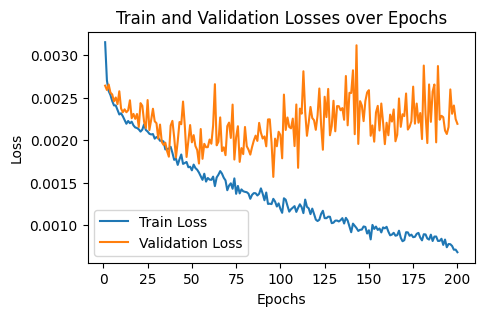

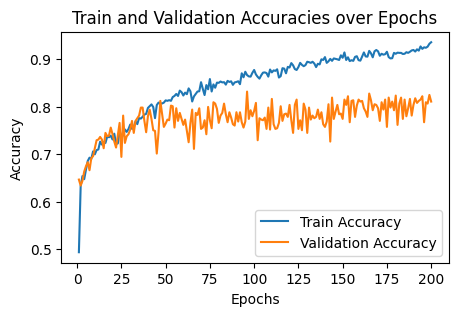

In [32]:
#Loss and accuracy plot
plot_losses(train_losses, valid_losses, config.EPOCH)
plot_accuracies(train_accuracies, valid_accuracies, config.EPOCH)

In [30]:
# 제일 성능이 좋은 모델 불러오기
model.load_state_dict(torch.load("/home/user/Desktop/bsh/absoluteA/model/2000_Transformer_best_model.pth"))
Macro_f1, auroc, accuracy, all_labels, all_probabilities = test(model, test_loader)
print(f"Best epoch: {best_epoch_save}")
print(f"macro F1 Score: {Macro_f1}")
print(f"AUROC: {auroc}")
print(f"Accuracy: {accuracy}")

100%|██████████| 3/3 [00:00<00:00, 11.87it/s]

Best epoch: 96
macro F1 Score: 0.761060170002008
AUROC: 0.9072886989553657
Accuracy: 0.7759103641456583


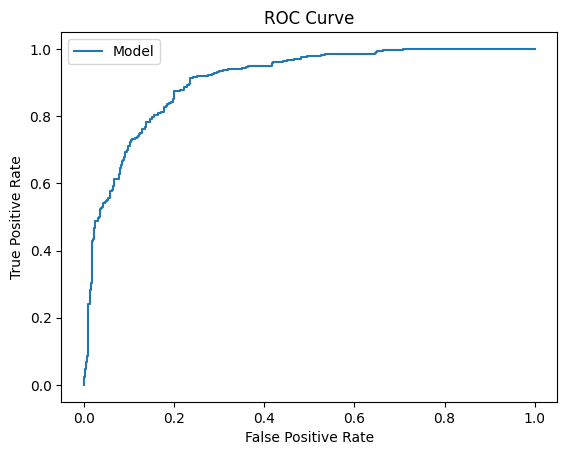

In [34]:
# AUROC plot
plot_roc_curve(all_labels, all_probabilities)